In [1]:
# General imports
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

# GluonTS imports
from gluonts.dataset.common import ListDataset
from gluonts.torch.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.dataset.split import split

# SimbaML imports
from simba_ml.simulation import distributions, generators
from simba_ml.simulation import kinetic_parameters as kinetic_parameters_module
from simba_ml.simulation import noisers
from simba_ml.simulation import species, system_model


In [78]:
real_data =  pd.read_csv('data/rki_case_numbers_germany.csv')
real_data = real_data.loc[50:150].reset_index(drop=True)
real_target = [{"target": real_data["new_cases_7d_average"].to_numpy(), "start": start_date}]

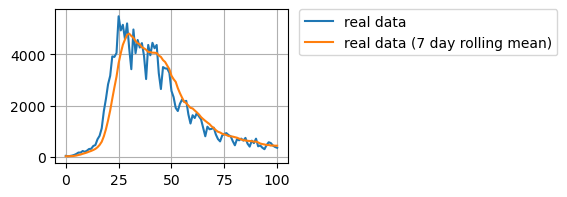

In [112]:
fig, ax = plt.subplots(figsize=(3,2))
ax.plot(real_data['new_cases'], label='real data')
ax.plot(real_data['new_cases_7d_average'], label='real data (7 day rolling mean)')

ax.legend(loc=(1.05,0.7))
ax.grid()

In [23]:
real_dataset = ListDataset(real_target, freq='d')
train_real, test_gen = split(real_dataset, offset=offset)

In [114]:
name = "SIR - Covid-19 - Data Augmentation"

specieses = [
    species.Species("Suspectible", distributions.Constant(83166711-100), contained_in_output=False, min_value=0), #83166711
    species.Species("Infected", distributions.Constant(100), contained_in_output=False, min_value=0),
    species.Species("Recovered", distributions.Constant(0), contained_in_output=False, min_value=0),
    species.Species("Cumulative Infected", distributions.Constant(100), contained_in_output=True, min_value=0),
]

kinetic_parameters: dict[str, kinetic_parameters_module.KineticParameter] = {
    "beta": kinetic_parameters_module.ConstantKineticParameter(distributions.ContinuousUniformDistribution(0.32, 0.35)),
    "gamma": kinetic_parameters_module.ConstantKineticParameter(distributions.ContinuousUniformDistribution(0.123, 0.125)),
}

def deriv(_t: float, y: list[float], arguments: dict[str, float]) -> tuple[float, float, float]:
    """Defines the derivative of the function at the point _.

    Args:
        y: Current y vector.
        arguments: Dictionary of arguments configuring the problem.

    Returns:
        Tuple[float, float, float]
    """
    S, I, R, _ = y
    N = S + I + R
    

    dS_dt = -arguments["beta"] * S * I / N
    dI_dt = arguments["beta"] * S * I / N - (arguments["gamma"]) * I
    dR_dt = arguments["gamma"] * I
    dC_dt = arguments["beta"] * S * I / N
    return dS_dt, dI_dt, dR_dt, dC_dt



noiser = noisers.AdditiveNoiser(distributions.NormalDistribution(0, 42*10**3))

sm = system_model.SystemModel(
            name,
            specieses,
            kinetic_parameters,
            deriv=deriv,
            noiser=noiser,
            timestamps=distributions.Constant(100)
        )
    


In [115]:
simulations = generators.TimeSeriesGenerator(sm).generate_signals(n=73)
simulations_new_cases = [simulation.assign(new_cases = simulation["Cumulative Infected"].diff()) for simulation in simulations]
sim_targets = [{"target": simulation["new_cases"].to_numpy(), "start": start_date} for simulation in simulations_new_cases]

In [121]:
np.diff(all_sim_data[0])

array([             nan,   17933.82232458, -108062.88981353,
        123481.37955927,  -40343.0318148 , -184338.03804638,
        249885.2604999 ,  -81922.98326124,    1047.52569733,
         47927.52413632, -133237.88580778,  179354.40134345,
       -145015.37470702,   45175.88150762,  124977.79489851,
       -185200.46619629,  103116.40483809,  -58341.81063783,
         29364.37707006,   -8877.28833083,   42619.60948833,
       -124384.20717664,  171132.36655469,  -72120.329386  ,
       -146931.73759623,  219901.90234347,  -28119.541737  ,
        -17234.74245707,  -62996.77944924,   26755.57893839,
         63796.05605269,  -41827.55977374,    3911.0077499 ,
        -12191.62576002,   26579.01231265,    4954.42366261,
         30559.05434781,   83309.26966184,  -30194.72765659,
        158482.77783959, -156351.82177484,  289925.39790972,
       -154485.65542239,  175771.35690229,  197020.91561047,
       -103094.31040979,  232130.32327548,  242797.56635538,
        102966.792848  ,

In [126]:
all_sim_data = np.array([np.diff(sim_target['target'], prepend=[0]) for sim_target in sim_targets])
all_sim_data.shape

(73, 100)

In [127]:
date_idx = np.arange(1,all_sim_data.shape[1]+1)
all_sim_data_mean = all_sim_data.mean(axis=0)
all_sim_data_std = all_sim_data.std(axis=0)

In [128]:
real_target[0]['target'].shape

(101,)

[None]

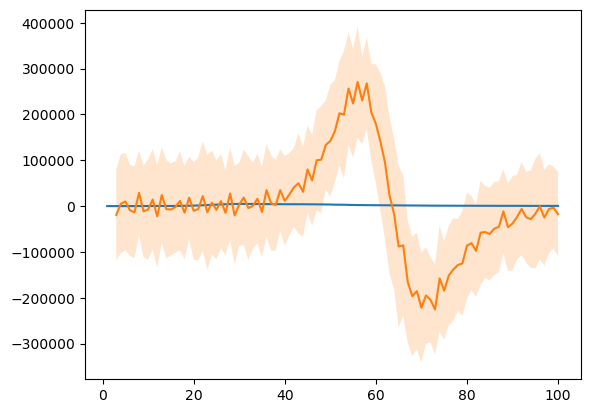

In [131]:
fig, ax = plt.subplots()

ax.plot(date_idx, real_target[0]['target'][:-1])
ax.plot(date_idx, all_sim_data_mean)
ax.fill_between(date_idx, all_sim_data_mean + all_sim_data_std, 
                          all_sim_data_mean - all_sim_data_std,
               alpha=0.2, facecolor='C1')

#for sim_data in all_sim_data:
#    ax.plot(date_idx, sim_data, alpha=0.01, c='k')

ax.set(yscale='linear')

In [ ]:
ax.